# Import Libraries

In [2]:
# import library
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
import pickle


# Membaca Dataset hasil preprocessing

In [3]:
# membaca data hasil preprocessing
data = pd.read_csv('dataset/hasil_stemming.csv')
data.head()

,userName,Review
0,Ekfari Ant,kenapa mitra di gabung dengan aplikasi utama s...
1,Bima Saputra,mantap lah
2,Sanusi ok,mantap
3,yanto totti,mantap sesuai yang ingin
4,Ahmad Murtado,oke


In [4]:
data.shape

(1678, 2)

## Labeling

In [5]:
# 1. Baca file lexicon positif dan negatif
pos_path = 'dataset/lexicon_positive.csv'
neg_path = 'dataset/lexicon_negative.csv'

# 2. Load CSV sebagai DataFrame
df_pos = pd.read_csv(pos_path)
df_neg = pd.read_csv(neg_path)

# 3. Buat kamus dari kolom word dan score
lexicon_positive = dict(zip(df_pos['word'].str.lower(), df_pos['score']))
lexicon_negative = dict(zip(df_neg['word'].str.lower(), df_neg['score']))

# 4. Fungsi analisis sentimen
def sentiment_analysis_lexicon(text):
    score = 0
    words = text.lower().split()

    for word in words:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score -= lexicon_negative[word]

    if score > 0:
        sentiment = 'positif'
    elif score < 0:
        sentiment = 'negatif'
    else:
        sentiment = 'netral'

    return score, sentiment

In [6]:
# Terapkan fungsi ke kolom Review
results = data['Review'].apply(sentiment_analysis_lexicon)
results = list(zip(*results))
data['score'] = results[0]
data['Sentimen'] = results[1]

In [7]:
# menampilkan hasil
data.head()

,userName,Review,score,Sentimen
0,Ekfari Ant,kenapa mitra di gabung dengan aplikasi utama s...,0,netral
1,Bima Saputra,mantap lah,2,positif
2,Sanusi ok,mantap,2,positif
3,yanto totti,mantap sesuai yang ingin,2,positif
4,Ahmad Murtado,oke,1,positif


In [8]:
# encoding label sentimen jadi numerik
data['y'] = data['Sentimen'].map({'positif': 2, 'negatif': 0, 'netral': 1})

In [9]:
data.head()

,userName,Review,score,Sentimen,y
0,Ekfari Ant,kenapa mitra di gabung dengan aplikasi utama s...,0,netral,1
1,Bima Saputra,mantap lah,2,positif,2
2,Sanusi ok,mantap,2,positif,2
3,yanto totti,mantap sesuai yang ingin,2,positif,2
4,Ahmad Murtado,oke,1,positif,2


# Training dataset menggunakan W2Vec

In [10]:
# Training Word2Vec
model_w2v = Word2Vec(sentences=data['Review'], vector_size=250, window=5, min_count=1, workers=4)
# menyimpan model w2v
model_w2v.save("models/model_w2v.model")


**Mengubah kalimat jadi vector**

In [11]:
# fungsi untuk mengubah kalimat menjadi vektor
def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)



In [12]:
# Buat X (fitur) menjadi vektor
X = np.array([sentence_vector(sent, model_w2v) for sent in data['Review']])
Y = data['y'].values

In [13]:
# menampilkan X dan Y yang sudah format vektor
display(
    X, Y
)

array([[ 0.06652508, -0.05652302,  0.06623229, ...,  0.01193473,
        -0.05724082,  0.11265411],
       [ 0.06137762, -0.05425477,  0.05824257, ...,  0.01536214,
        -0.05790101,  0.10461821],
       [ 0.06276721, -0.053807  ,  0.06001196, ...,  0.01103191,
        -0.06110264,  0.1127708 ],
       ...,
       [ 0.06540269, -0.05634982,  0.06461189, ...,  0.01407956,
        -0.05640594,  0.10983858],
       [ 0.06515504, -0.0528092 ,  0.05060536, ...,  0.01977276,
        -0.0605451 ,  0.11045523],
       [ 0.06425936, -0.05563464,  0.06356111, ...,  0.01550481,
        -0.05698438,  0.11432547]], dtype=float32)

array([1, 2, 2, ..., 2, 2, 1])

In [14]:
# menampilkan distribusi label (nilai unik dan jumlahnya)
np.unique(Y, return_counts=True)

(array([0, 1, 2]), array([160, 826, 692]))

# Splitting Data

Rasio splitting data 70:30 - 80:20

In [15]:
# splitting data 70:30
x70_train, x70_test, y30_train, y30_test = train_test_split(X, Y, random_state=0, stratify=Y, train_size=0.7)
# splitting data 80:20
x80_train, x80_test, y20_train, y20_test = train_test_split(X, Y, random_state=0, stratify=Y, train_size=0.8)

In [16]:
# ukuran data 70:30
display(
    x70_train.shape, y30_train.shape,
)  
# ukuran data 80:20
display(
    x80_train.shape, y20_train.shape
)

(1174, 250)

(1174,)

(1342, 250)

(1342,)

/var/folders/yf/qt8_6rfn58z6h6y2phqypdxr0000gn/T/ipykernel_19056/3346986792.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax0.set_xticklabels(['Negatif', 'Netral', 'Positif'])
/var/folders/yf/qt8_6rfn58z6h6y2phqypdxr0000gn/T/ipykernel_19056/3346986792.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['Negatif', 'Netral', 'Positif'])


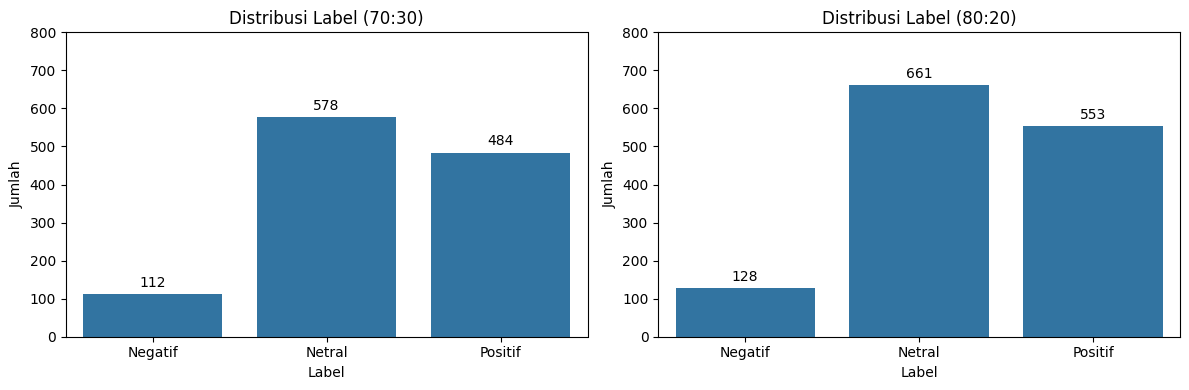

In [17]:
# tampilkan distribusi
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# 
ax0 = ax[0]
plot1 = sns.countplot(x=y30_train, ax=ax0)
ax0.set_title('Distribusi Label (70:30)')
ax0.set_xlabel('Label')
ax0.set_ylabel('Jumlah')
ax0.set_ylim(0, 800)
ax0.set_xticklabels(['Negatif', 'Netral', 'Positif'])
for container in [plot1.containers[0]]:
    ax0.bar_label(container, label_type='edge', fontsize=10, padding=3)

ax1 = ax[1]
plot2 = sns.countplot(x=y20_train, ax=ax1)
ax1.set_title('Distribusi Label (80:20)')
ax1.set_xlabel('Label')
ax1.set_ylabel('Jumlah')
ax1.set_ylim(0, 800)
ax1.set_xticklabels(['Negatif', 'Netral', 'Positif'])
for container in [plot2.containers[0]]:
    ax1.bar_label(container, label_type='edge', fontsize=10, padding=3)
plt.tight_layout()
plt.show()

# Modeling KNN dan RF Awal

In [18]:
# membuat list data untuk efisiensi
xtrain = [x70_train, x80_train]
ytrain = [y30_train, y20_train]
xtest = [x70_test, x80_test]
ytest = [y30_test, y20_test]

In [19]:
def metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    return acc, f1, prec, rec

In [20]:
def evaluate_model(model, xtrainlist, ytrainlist, xtestlist, ytestlist):
    result = {
        'model': [],
        'splitting_data': [],
        'accuracy_score': [],
        'f1_score': [],
        'precision_score': [],
        'recall_score': []
    }
    name = model.__class__.__name__
    train_size = ['70:30', '80:20']

    if len(xtrainlist)==1:
        model.fit(xtrainlist[0], ytrainlist[0])
        ypred = model.predict(xtestlist[0])
        acc, f1, precision, recall = metrics(ytestlist[0], ypred)
        result['model'].append(name)
        result['splitting_data'].append(train_size[0])
        result['accuracy_score'].append(acc)
        result['f1_score'].append(f1)
        result['precision_score'].append(precision)
        result['recall_score'].append(recall)
        return pd.DataFrame(result)
    
  # perulangan berdasarkan index ke-0 dan ke-1 (2 data split)
    for i in range(len(train_size)):
        xtrain = xtrainlist[i]
        ytrain = ytrainlist[i]
        xtest = xtestlist[i]
        ytest = ytestlist[i]

        model.fit(xtrain, ytrain)
        ypred = model.predict(xtest)
        acc, f1, precision, recall = metrics(ytest, ypred)

        result['model'].append(name)
        result['splitting_data'].append(train_size[i])
        result['accuracy_score'].append(acc)
        result['f1_score'].append(f1)
        result['precision_score'].append(precision)
        result['recall_score'].append(recall)

    return pd.DataFrame(result)


#### Model Awal RF dan KNN Sebelum Teknik SMOTE

In [21]:
# inisialisasi model random forest
rf = RandomForestClassifier(random_state=0)
# hasil model RF sebelum SMOTE
evaluate_model(rf, xtrain, ytrain, xtest, ytest)

,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,RandomForestClassifier,70:30,0.708333,0.671644,0.705852,0.708333
1,RandomForestClassifier,80:20,0.693452,0.665745,0.700309,0.693452


In [22]:
# inisialisasi model KNN
knn = KNeighborsClassifier(n_neighbors=5)  
# hasil model KNN sebelum SMOTE
evaluate_model(knn, xtrain, ytrain, xtest, ytest)

,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,KNeighborsClassifier,70:30,0.644841,0.639618,0.640658,0.644841
1,KNeighborsClassifier,80:20,0.630952,0.625803,0.626966,0.630952


#### Model Awal RF dan KNN Sesudah Teknik SMOTE

In [23]:
smote = SMOTE(random_state=0) # inisialisasi SMOTE
# melakukan oversampling pada data latih
x70train_smote, y30train_smote = smote.fit_resample(x70_train, y30_train)
x80_train_smote, y20_train_smote = smote.fit_resample(x80_train, y20_train)


In [24]:
# ukuran data 70:30 setelah smote
display(
    x70train_smote.shape, y30train_smote.shape,
)

# ukuran data 80:20 setelah smote
display(
    x80_train_smote.shape, y20_train_smote.shape,
)

(1734, 250)

(1734,)

(1983, 250)

(1983,)

In [25]:
# list data train smote
x_train_smote = [x70train_smote, x80_train_smote]
y_train_smote = [y30train_smote, y20_train_smote]

In [26]:
# evaluasi model RF setelah SMOTE
evaluate_model(rf, x_train_smote, y_train_smote, xtest, ytest)

,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,RandomForestClassifier,70:30,0.676587,0.679689,0.695834,0.676587
1,RandomForestClassifier,80:20,0.690476,0.695942,0.721703,0.690476


In [27]:
# evaluasi model KNN setelah SMOTE
evaluate_model(knn, x_train_smote, y_train_smote, xtest, ytest)

,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,KNeighborsClassifier,70:30,0.573413,0.604204,0.668636,0.573413
1,KNeighborsClassifier,80:20,0.535714,0.567524,0.636303,0.535714


#### Model Boosting sebelum SMOTE

In [28]:
# LGBM
lgb = LGBMClassifier(random_state=0)
# evaluasi model LGBM sebelum SMOTE
evaluate_model(lgb, xtrain, ytrain, xtest, ytest)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63577
[LightGBM] [Info] Number of data points in the train set: 1174, number of used features: 250
[LightGBM] [Info] Start training from score -2.349673
[LightGBM] [Info] Start training from score -0.708598
[LightGBM] [Info] Start training from score -0.886087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63617
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 250
[LightGBM] [Info] Start training from score -2.349886
[LightGBM] [Info] Start training from score -0.708162
[LightGBM] [Info] Start training from score -0.886558


,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,LGBMClassifier,70:30,0.712302,0.686199,0.684025,0.712302
1,LGBMClassifier,80:20,0.723214,0.700980,0.730208,0.723214


In [29]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0)
# evaluasi model XGB sebelum SMOTE
evaluate_model(xgb, xtrain, ytrain, xtest, ytest)

/Users/apa/.pyenv/versions/3.10.12/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/apa/.pyenv/versions/3.10.12/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,XGBClassifier,70:30,0.700397,0.680688,0.682934,0.700397
1,XGBClassifier,80:20,0.708333,0.688825,0.697830,0.708333


In [30]:
# Gradient Boosting
grad = GradientBoostingClassifier(random_state=0)
evaluate_model(grad, xtrain, ytrain, xtest, ytest)

,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,GradientBoostingClassifier,70:30,0.712302,0.690986,0.701912,0.712302
1,GradientBoostingClassifier,80:20,0.717262,0.690335,0.710633,0.717262


#### Model Boosting Sesudah SMOTE

In [31]:
# lgbm
evaluate_model(lgb, x_train_smote, y_train_smote, xtest, ytest)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63657
[LightGBM] [Info] Number of data points in the train set: 1734, number of used features: 250
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63666
[LightGBM] [Info] Number of data points in the train set: 1983, number of used features: 250
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,LGBMClassifier,70:30,0.694444,0.692357,0.694038,0.694444
1,LGBMClassifier,80:20,0.702381,0.703710,0.715261,0.702381


In [32]:
# XGBoost
evaluate_model(xgb, x_train_smote, y_train_smote, xtest, ytest)

/Users/apa/.pyenv/versions/3.10.12/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:58:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/apa/.pyenv/versions/3.10.12/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:59:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,XGBClassifier,70:30,0.702381,0.701966,0.705843,0.702381
1,XGBClassifier,80:20,0.729167,0.731239,0.747232,0.729167


In [33]:
# gradient Boosting
evaluate_model(grad, x_train_smote, y_train_smote, xtest, ytest)

,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,GradientBoostingClassifier,70:30,0.682540,0.690362,0.707896,0.682540
1,GradientBoostingClassifier,80:20,0.699405,0.712864,0.735684,0.699405


## Model KNN + Boosting

In [34]:
lgb2 = LGBMClassifier(random_state=0)
lgb2.fit(x80_train.astype('float32'), y20_train)
# output lgbm untuk prediksi menggunakan knn
xtrain_lgbm = lgb.predict_proba(x80_train.astype('float32'))
xtest_lgbm = lgb.predict_proba(x80_test.astype('float32'))

# model KNN + Boosting
knn_lgbm = KNeighborsClassifier(n_neighbors=5)
knn_lgbm.fit(xtrain_lgbm, y20_train)
# evaluasi model KNN + Boosting
evaluate_model(knn_lgbm, [xtrain_lgbm], [y20_train], [xtest_lgbm], [y20_test])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63617
[LightGBM] [Info] Number of data points in the train set: 1342, number of used features: 250
[LightGBM] [Info] Start training from score -2.349886
[LightGBM] [Info] Start training from score -0.708162
[LightGBM] [Info] Start training from score -0.886558


,model,splitting_data,accuracy_score,f1_score,precision_score,recall_score
0,KNeighborsClassifier,70:30,0.705357,0.705263,0.715725,0.705357


In [35]:
xtrain_lgbm

array([[9.98281735e-01, 6.80106759e-04, 1.03815852e-03],
       [5.50854420e-03, 9.89196420e-01, 5.29503536e-03],
       [1.01804516e-03, 1.34811733e-02, 9.85500781e-01],
       ...,
       [8.85876498e-06, 5.82995993e-05, 9.99932842e-01],
       [9.97725243e-01, 2.02965949e-03, 2.45097164e-04],
       [4.50923788e-03, 9.11193613e-03, 9.86378826e-01]])

In [36]:
with open("models/lgb.pkl", "wb") as f:
    pickle.dump(lgb2, f)

In [37]:
with open("models/knn_lgbm.pkl", "wb") as f:
    pickle.dump(knn_lgbm, f)